In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.core.pylabtools import figsize

from scipy.stats import uniform, gamma, poisson
import matplotlib.pyplot as plt
import numpy
from numpy import log,exp
from numpy.random import multinomial

# fix the random seed for replicability.
numpy.random.seed(123456789)

In [2]:
# Hyperparameters
N=50
a=2
b=1

# Change-point: where the intensity parameter changes.
n=int(round(uniform.rvs()*N))
print(n)

27


In [3]:
# Intensity values
lambda1=gamma.rvs(a,scale=1./b) # We use 1/b instead of b because of the way Gamma distribution is parametrized in the package random.
lambda2=gamma.rvs(a,scale=1./b)

In [4]:
lambdas=[lambda1]*n
lambdas[n:N-1]=[lambda2]*(N-n)

# Observations, x_1 ... x_N
x=poisson.rvs(lambdas)

In [7]:
# Gibbs sampler
E=5200
BURN_IN=200

# Initialize the chain
n=int(round(uniform.rvs()*N))
lambda1=gamma.rvs(a,scale=1./b)
lambda2=gamma.rvs(a,scale=1./b)

# Store the samples
chain_n=numpy.array([0.]*(E-BURN_IN))
chain_lambda1=numpy.array([0.]*(E-BURN_IN))
chain_lambda2=numpy.array([0.]*(E-BURN_IN))

In [8]:
for e in range(E):
#     print "At iteration "+str(e)

    lambda1=gamma.rvs(a+sum(x[0:n]), scale=1./(n+b))
    lambda2=gamma.rvs(a+sum(x[n:N]), scale=1./(N-n+b))

    # sample n, Equation 10
    mult_n=numpy.array([0]*N)
    for i in range(N):
        mult_n[i]=sum(x[0:i])*log(lambda1)-i*lambda1+sum(x[i:N])*log(lambda2)-(N-i)*lambda2
    mult_n=exp(mult_n-max(mult_n))
    # 计算出 n 是一个多项分布，进行采样
    n=numpy.where(multinomial(1,mult_n/sum(mult_n),size=1)==1)[1][0]

    # store
    if e>=BURN_IN:
        chain_n[e-BURN_IN]=n
        chain_lambda1[e-BURN_IN]=lambda1
        chain_lambda2[e-BURN_IN]=lambda2

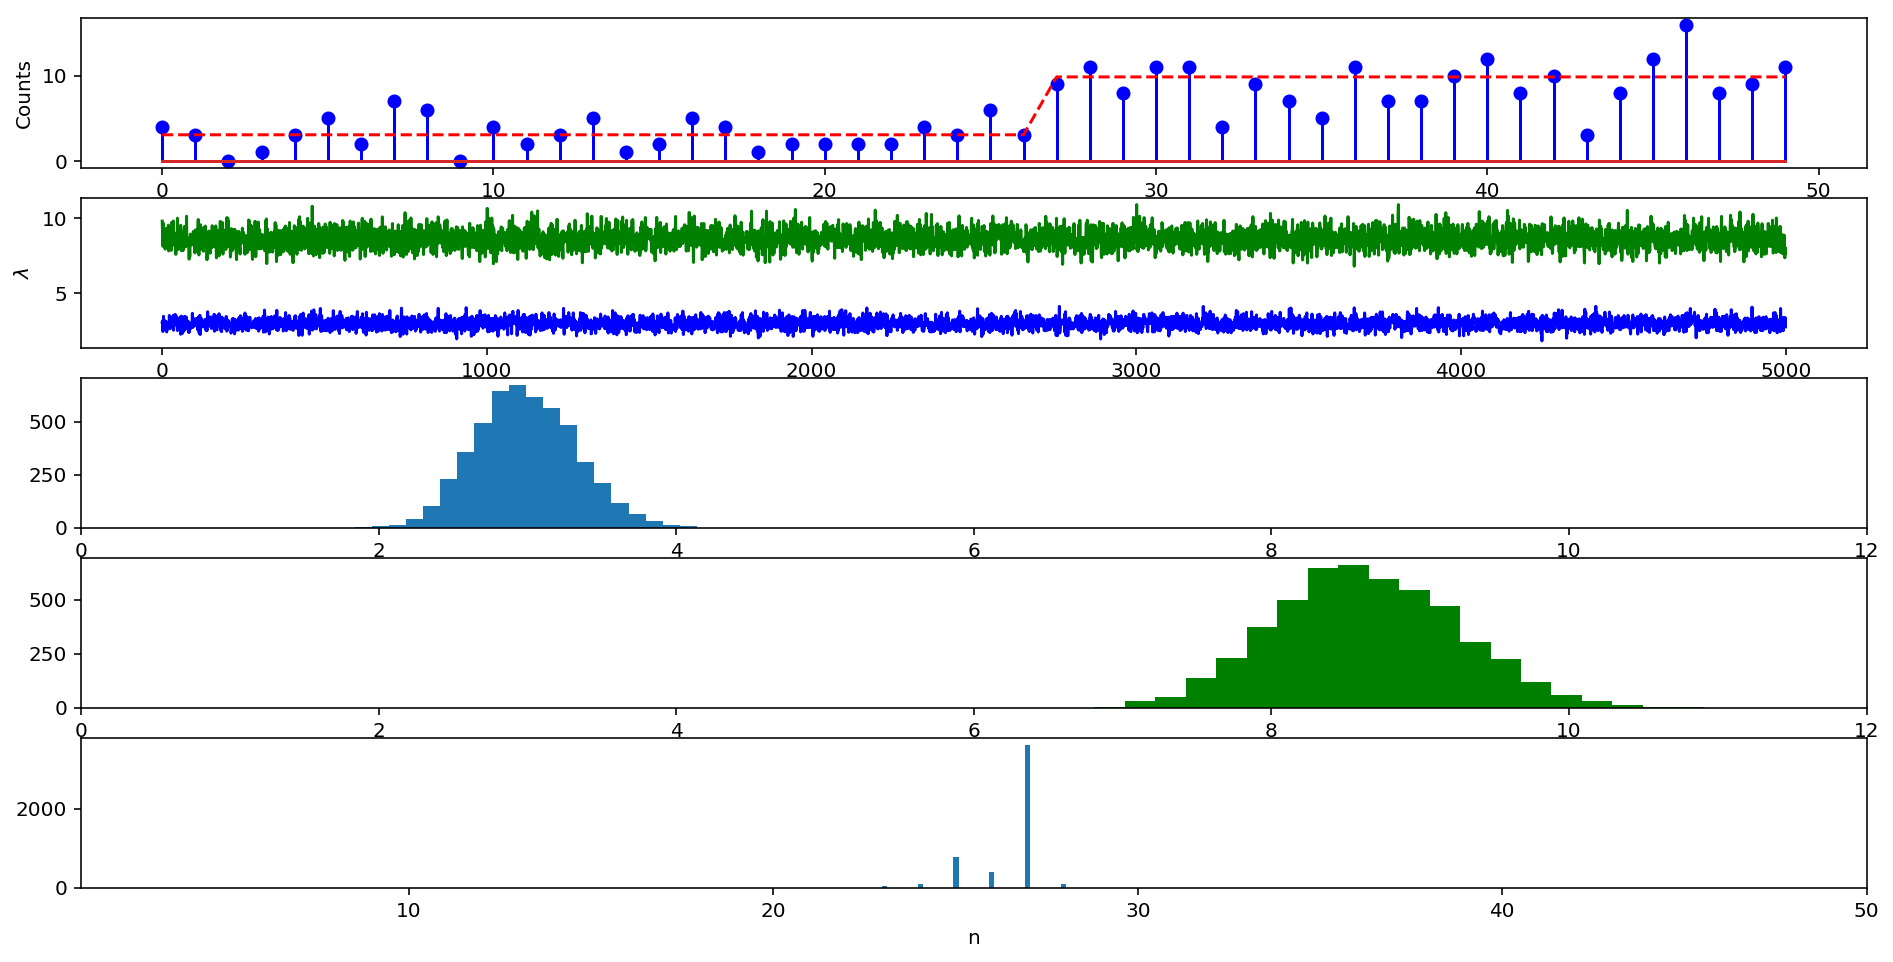

In [9]:
figsize(16,8)
# make one big subplots and put everything in it.
f, (ax1,ax2,ax3,ax4,ax5)=plt.subplots(5,1)
# Plot the data
ax1.stem(range(N),x,linefmt='b-', markerfmt='bo')
ax1.plot(range(N),lambdas,'r--')
ax1.set_ylabel('Counts')

ax2.plot(chain_lambda1,'b',chain_lambda2,'g')
ax2.set_ylabel('$\lambda$')
ax3.hist(chain_lambda1,20)
ax3.set_xlabel('$\lambda_1$')
ax3.set_xlim([0,12])
ax4.hist(chain_lambda2,20,color='g')
ax4.set_xlim([0,12])
ax4.set_xlabel('$\lambda_2$')
ax5.hist(chain_n,50)
ax5.set_xlabel('n')
ax5.set_xlim([1,50])
plt.show()

In [12]:
numpy.where(multinomial(1,[0.1,0.2,0.3,0.4],size=1))

(array([0]), array([3]))

## pymc3
![](http://static.zybuluo.com/zhuanxu/bewdrn3nraazmdyrd6pl90a8/image_1c4es7o6a1qkul38et9di4g0g13.png)

下面我们先产生真实的数据

In [25]:
N = 50
a = 2
b = 1


# Change-point: where the intensity parameter changes.
n=int(round(uniform.rvs()*N))
print(n)

# Intensity values
lambda1=gamma.rvs(a,scale=1./b) # We use 1/b instead of b because of the way Gamma distribution is parametrized in the package random.
lambda2=gamma.rvs(a,scale=1./b)

lambdas=[lambda1]*n
lambdas[n:N-1]=[lambda2]*(N-n)

# Observations, x_1 ... x_N
x=poisson.rvs(lambdas)

25


In [27]:
print(n, lambda1, lambda2)

25 1.40299540675 3.51733923078


Text(0,0.5,'Counts')

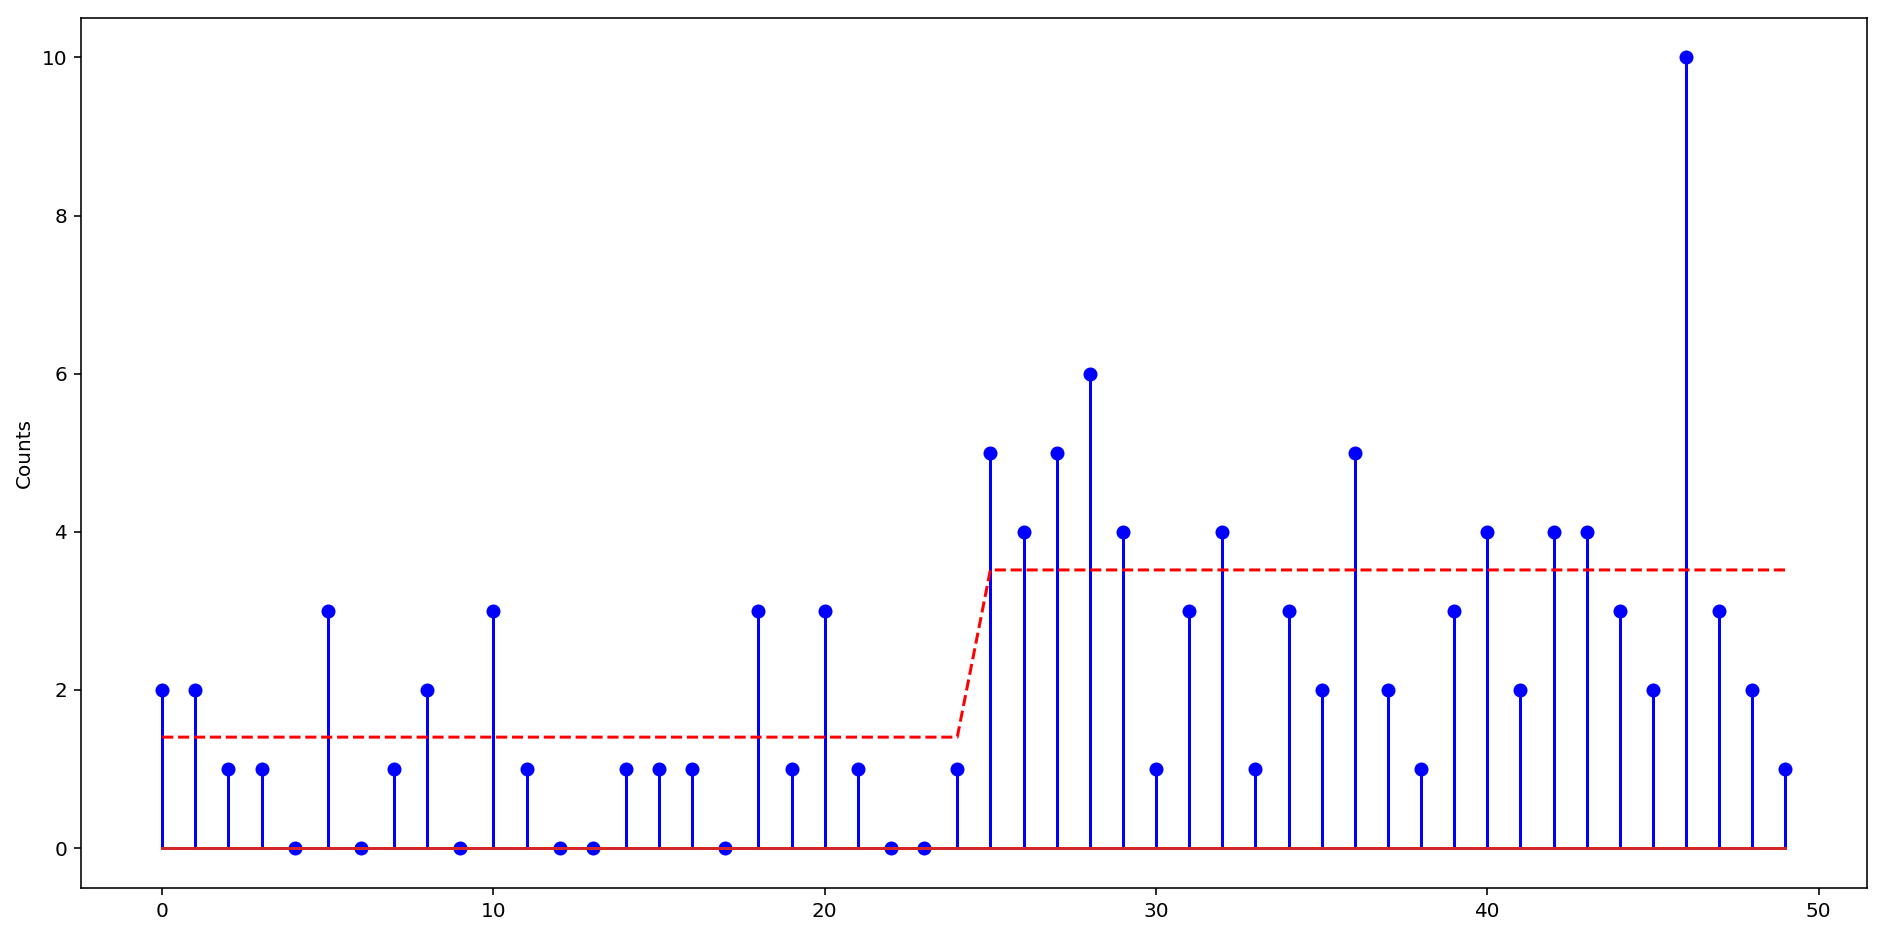

In [26]:
figsize(16,8)
# make one big subplots and put everything in it.
f, ax1 =plt.subplots(1,1)
# Plot the data
ax1.stem(range(N),x,linefmt='b-', markerfmt='bo')
ax1.plot(range(N),lambdas,'r--')
ax1.set_ylabel('Counts')

In [29]:
import pymc3 as pm
import numpy as np

In [31]:
model = pm.Model()
with model:
    n = pm.DiscreteUniform("n",lower=1,upper=N)
    lambda_1 = pm.Gamma("lambda_1",alpha=a, beta=b)
    lambda_2 = pm.Gamma("lambda_2",alpha=a, beta=b)
    idx = np.arange(N) # Index
    lambda_ = pm.math.switch(n > idx, lambda_1, lambda_2)
    observation = pm.Poisson("obs", lambda_, observed=x)
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

100%|██████████| 15000/15000 [00:08<00:00, 1828.02it/s]


In [32]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
n_samples = trace['n']

In [34]:
lambda_1_samples

array([ 1.37653082,  1.17194904,  1.17194904, ...,  0.92749051,
        1.35088672,  1.35088672])

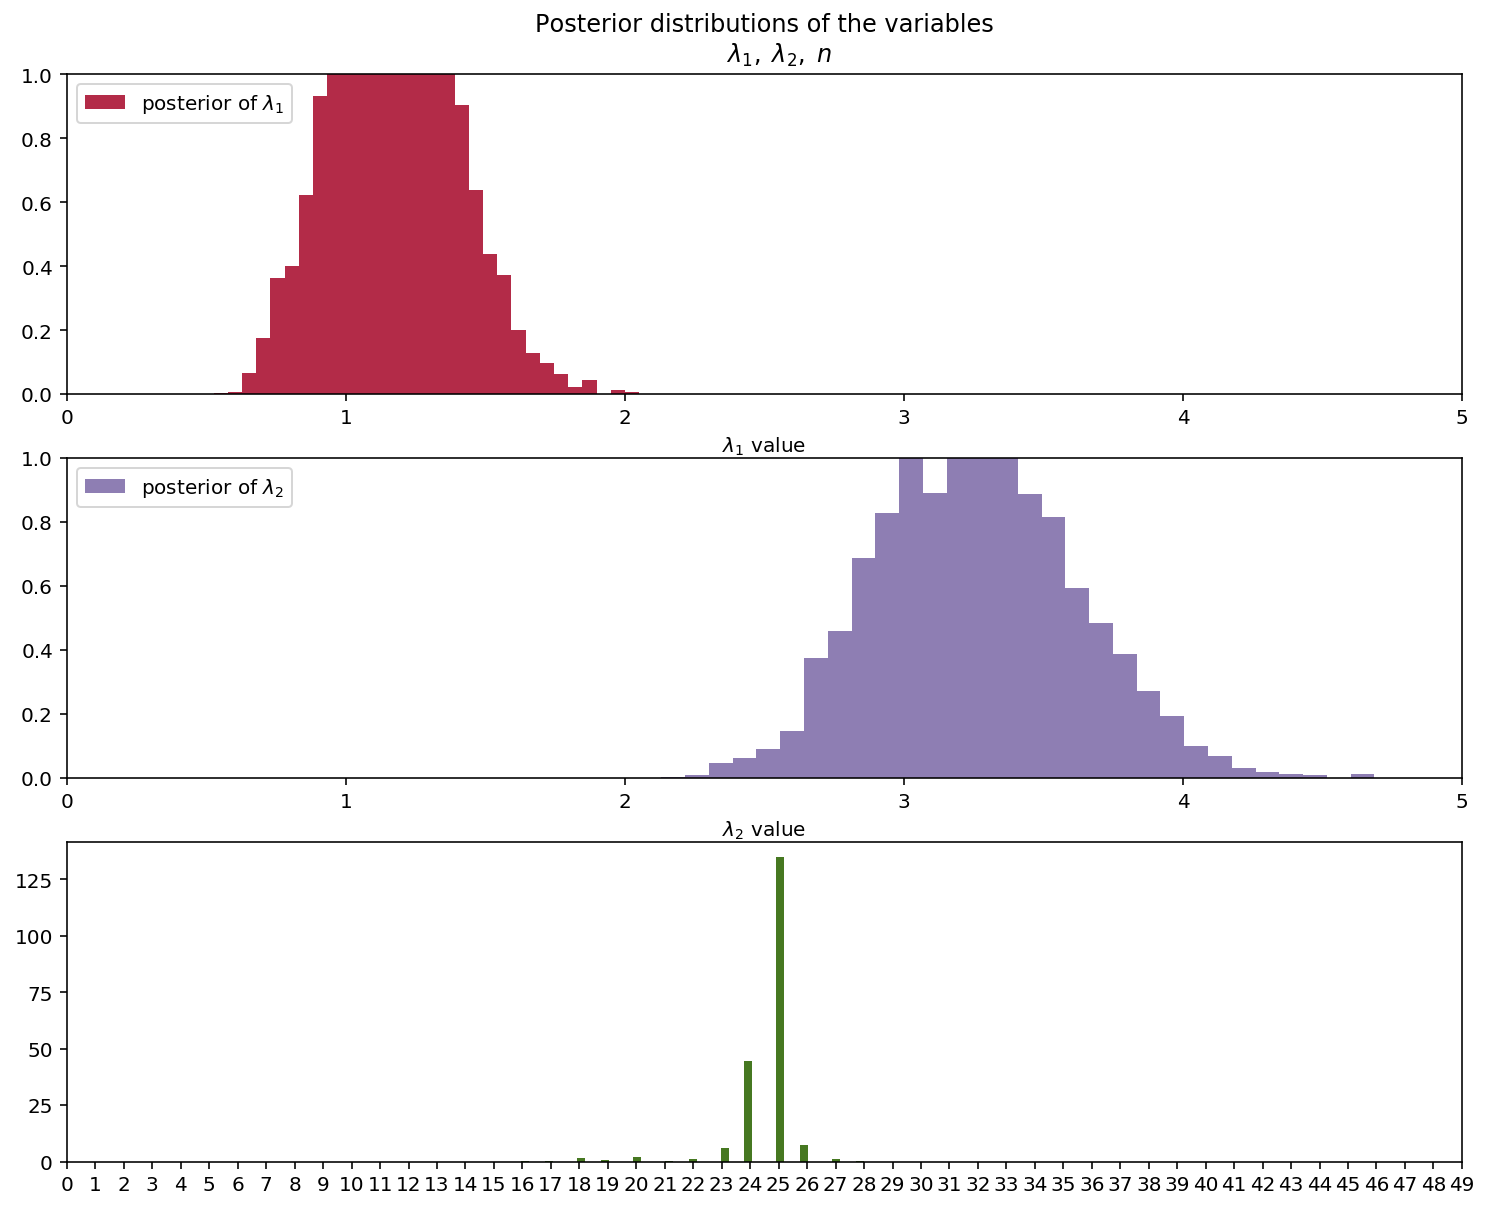

In [43]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;n$""")
plt.xlim([0, 5])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([0, 5])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / N * np.ones_like(n_samples)
_=plt.hist(n_samples, bins=N, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
_=plt.xticks(np.arange(N))

# plt.legend(loc="upper left")
# plt.ylim([0, .75])
# plt.xlim([35, len(count_data)-20])
# plt.xlabel(r"$\tau$ (in days)")
# plt.ylabel("probability");